In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Imputation
from sklearn.impute import SimpleImputer, KNNImputer

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

# Machine-learning stack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
#from scipy.stats import boxcox, yeojohnson

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

# Evaluation Functions

In [2]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value
    
def predict_and_print_scores(model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,                             
                             training=True,
                             test=True,
                             accuracy=True,
                             recall=True,
                             precision=True,
                             fbeta=[True, 1.0],
                             roc_auc=True,
                             pauc=True,
                             matrix=True,
                             figsize=(3,2),
                             cmap='YlGn'):
    
    '''
    Given an already trained model, this function predicts and print some performance scores training and/or testing data.
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model             Trained model
    X_train           Training data with features
    y_train           Training data with labels or targets
    X_test            Testing data with features
    y_test            Testing data with labels or targets                             
    training=True     True: print scores on the training set
    test=True         True: print scores on the testing set
    accuracy=True     True: print accuracy_score()
    recall=True       True: print recall_score()
    precision=True    True: print precision_score()
    fbeta=[True, 1.0] [True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True      True: print roc_auc_score()
    matrix=True       True: plot confusion matrix
    figsize=(3,2)     Figure size for the confusion matrix
    cmap='YlGn')      Color map for the confusion matrix
    
    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns: fig, ax: the figure objects of the cunfusion matrix (if enabled)
    '''

    # Prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
            
    # Scores
    if accuracy:
        if training:
            print("Accuracy on training set:", round(accuracy_score(y_train, y_pred_train), 2))
        if test:
            print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if recall:        
        if training:
            print("Recall on training set:", round(recall_score(y_train, y_pred_train), 2))
        if test:
            print("Recall on test set:", round(recall_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if precision:
        if training:
            print("Precision on training set:", round(precision_score(y_train, y_pred_train), 2))
        if test:
            print("Precision on test set:", round(precision_score(y_test, y_pred_test), 2))
        print("--------"*5)

    if fbeta[0]:
        if training:
            print("fbeta_score on training set:", round(fbeta_score(y_train, y_pred_train, beta=fbeta[1]), 2))
        if test:
            print("fbeta_score on test set:", round(fbeta_score(y_test, y_pred_test, beta=fbeta[1]), 2))
        print("--------"*5)

    if roc_auc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('roc_auc_score on trainig set: ', round(roc_auc_score(y_train, y_pred_train_p), 2))
        if test:
            print('roc_auc_score on test set: ', round(roc_auc_score(y_test, y_pred_test_p), 2))
        print("--------"*5)
        
    if pauc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('pAUC on trainig set: ', round(partial_auc_score(y_train, y_pred_train_p), 4))
        if test:
            print('pAUC on test set: ', round(partial_auc_score(y_test, y_pred_test_p), 4))
        print("--------"*5)
        
    # Plot confusion matrix 
    if matrix:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=cmap);
        plt.title('Test Set')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')                 
        
def train_crossval_predict_score(model,
                                 hyperparams,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cv=5,
                                 scoring='accuracy',
                                 verbose=0,
                                 n_jobs=-1,
                                 cross_val='full',
                                 n_iter=100,
                                 random_state='None',
                                 training=True,
                                 test=True,
                                 accuracy=True,
                                 recall=True,
                                 precision=True,
                                 fbeta=[True, 1.0],
                                 roc_auc=True,
                                 pauc=True,
                                 matrix=True,
                                 figsize=(3,2),
                                 cmap='YlGn'):
                                 
    '''
    Given an instantiated model, this function trains, cross-validate, predicts, and prints some performance scores training and/or testing data.
    The cross-validation strategy is selected with the input parameters "cross_val".
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model                 #Instantiated model
    hyperparams           #Dictionary including hyperparameters
    X_train               #Training data with features
    y_train               #Training data with labels or targets
    X_test                #Testing data with features
    y_test                #Testing data with labels or targets
    cv=5                  #Number of cross-validation folds
    scoring='accuracy'    #Scoring method
    verbose=0             #Verbose
    n_jobs=-1             #Number of jobs in parallel
    cross_val='full'      #'Full'/'full': Apply GridSearchCV. 'Random'/'random': Apply RandomSearchCV
    n_iter=100,           #Number of iterations for RandomSearchCV (unused for full search)
    random_state          #Random state parameter for RandomSearchCV: 'None' or an integer
    training=True         #True: print scores on the training set
    test=True             #True: print scores on the testing set
    accuracy=True         #True: print accuracy_score()
    recall=True           #True: print recall_score()
    precision=True        #True: print precision_score()
    fbeta=[True, 1.0]     #[True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True          #True: print roc_auc_score()
    matrix=True           #True: plot confusion matrix
    figsize=(3,2)         #Figure size for the confusion matrix
    cmap='YlGn'):         #Color map for the confusion matrix

    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns:
    - best_model: object of the best model after cross-validation
    - best_params: hyperparameters of the best model
    - fig, ax: the figure objects of the confusion matrix (if enabled)
'''

    # Cross-validation
    if cross_val == 'Full' or cross_val == 'full':
        grid_model = GridSearchCV(model, param_grid=hyperparams, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    elif cross_val == 'Random' or cross_val == 'random':        
        grid_model = RandomizedSearchCV(model, param_distributions=hyperparams, n_iter=n_iter, cv=cv, scoring=scoring, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
        
    # Fit
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    print('Best params:', grid_model.best_params_)
    print("--------"*5)
    
    # Predict and print results
    predict_and_print_scores(best_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             training=training,
                             test=test,
                             accuracy=accuracy,
                             recall=recall,
                             precision=precision,
                             fbeta=fbeta,
                             roc_auc=roc_auc,
                             pauc=pauc,
                             matrix=matrix,
                             figsize=figsize,
                             cmap=cmap)
    
    return best_model, best_params

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Model Loading

In [3]:
# Read the dataset
ROOT_DATASET_DIR = "./"
file_name = os.path.join(ROOT_DATASET_DIR,"train-metadata-eda-fe.csv")
df = pd.read_csv(file_name)

# Exploratory Data Analysis (EDA)

In [4]:
df.drop(columns=['isic_id'], inplace=True)
df['anatom_site_general'] = pd.Categorical(df['anatom_site_general'])
df['tbp_lv_location'] = pd.Categorical(df['tbp_lv_location'])
df['tbp_lv_location_simple'] = pd.Categorical(df['tbp_lv_location_simple'])

In [5]:
df.dtypes

target                               int64
age_approx                         float64
sex                                  int64
anatom_site_general               category
clin_size_long_diam_mm             float64
                                    ...   
sqrt_hue_color_std_interaction     float64
sqrt_normalized_lesion_size        float64
sqrt_color_variance_ratio          float64
sqrt_color_asymmetry_index         float64
sqrt_shape_color_consistency       float64
Length: 128, dtype: object

# Baseline Model: Logistic Regression (model_lr_log_red.pkl)

In [6]:
# Remove Unnecesary features

# Original feature names
features_to_be_logtr = ['clin_size_long_diam_mm',
                        'tbp_lv_areaMM2',
                        'tbp_lv_area_perim_ratio',
                        'tbp_lv_color_std_mean',
                        'tbp_lv_deltaLB',
                        'tbp_lv_deltaLBnorm',
                        'tbp_lv_minorAxisMM',
                        'tbp_lv_norm_border',
                        'tbp_lv_norm_color',
                        'tbp_lv_perimeterMM',
                        'tbp_lv_radial_color_std_max',
                        'tbp_lv_stdL',
                        'tbp_lv_stdLExt',
                        'tbp_lv_symm_2axis']
features_to_be_sqrtr = ['tbp_lv_eccentricity']

# Modified original feature names
log_features = ['log_' + col for col in features_to_be_logtr]
sqr_features = ['sqr_' + col for col in features_to_be_sqrtr]

# New feature names
new_features_to_be_logtr = ['hue_contrast',
                            'luminance_contrast',
                            'lesion_color_difference',
                            'border_complexity',
                            #'color_uniformity',
                            'perimeter_to_area_ratio',
                            'area_to_perimeter_ratio',
                            'lesion_visibility_score',
                            'symmetry_border_consistency',
                            'consistency_symmetry_border',
                            #'color_consistency',
                            'consistency_color',
                            'size_age_interaction',
                            'lesion_severity_index',
                            'shape_complexity_index',
                            #'normalized_lesion_size',
                            'std_dev_contrast',
                            'color_shape_composite_index',
                            'symmetry_perimeter_interaction',
                            'comprehensive_lesion_index',
                            #'color_variance_ratio',
                            'border_color_interaction',
                            'size_color_contrast_ratio',
                            'age_normalized_nevi_confidence',
                            #'color_asymmetry_index',
                            'volume_approximation_3d',
                            'color_range',
                            #'shape_color_consistency',
                            'age_size_symmetry_index',
                            'index_age_size_symmetry']
new_features_to_be_sqrtr = ['lesion_shape_index',
                            'position_distance_3d']
new_features_to_be_sqrttr = ['color_consistency',
                             'hue_color_std_interaction',
                             'normalized_lesion_size',
                            #'overall_color_difference',
                             'color_variance_ratio',
                             'color_asymmetry_index',
                             'shape_color_consistency']

# Modify the column names
log_new_features = ['log_' + col for col in new_features_to_be_logtr]
sqr_new_features = ['sqr_' + col for col in new_features_to_be_sqrtr]
sqrt_new_features = ['sqrt_' + col for col in new_features_to_be_sqrttr]


In [7]:
# Train-Test split
# Drop non-used features for the baseline + target
Xb = df.drop(['target']
             + features_to_be_logtr + features_to_be_sqrtr                                         # drop original features with skeweness (no transformation)                          
             + new_features_to_be_logtr + new_features_to_be_sqrtr + new_features_to_be_sqrttr     # drop new features with skeweness (no transformation)
             + log_new_features + sqr_new_features + sqrt_new_features,                            # drop new skewed features with transformation (log, sqr, sqrt)
             axis=1)
y = df['target']
Xb_train, Xb_test, y_train, y_test = train_test_split(Xb, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
model_lr_base = load('model_lr_baseline.pkl')

In [9]:
y_pred_train_b = model_lr_base.predict_proba(Xb_train)[:,1]
y_pred_test_b = model_lr_base.predict_proba(Xb_test)[:,1]
print('pAUC on trainig set: ', round(partial_auc_score(y_train, y_pred_train_b), 4))
print('pAUC on test set: ', round(partial_auc_score(y_test, y_pred_test_b), 4))
print("--------"*5)

pAUC on trainig set:  0.1487
pAUC on test set:  0.1367
----------------------------------------


# Baseline Model with Feature Engineering

In [10]:
# Train-Test split
# Drop non-used features for the baseline + target
X1 = df.drop(['target']
             + features_to_be_logtr + features_to_be_sqrtr                                         # drop original features with skeweness (no transformation)                          
             + new_features_to_be_logtr + new_features_to_be_sqrtr + new_features_to_be_sqrttr,    # drop new features with skeweness (no transformation)             
             axis=1)
X1_train, X1_test, _, _ = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
numerical_features = X1.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = X1.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['age_approx', 'sex', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_nevi_confidence', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'log_clin_size_long_diam_mm', 'log_tbp_lv_areaMM2', 'log_tbp_lv_area_perim_ratio', 'log_tbp_lv_color_std_mean', 'log_tbp_lv_deltaLB', 'log_tbp_lv_deltaLBnorm', 'log_tbp_lv_minorAxisMM', 'log_tbp_lv_norm_border', 'log_tbp_lv_norm_color', 'log_tbp_lv_perimeterMM', 'log_tbp_lv_radial_color_std_max', 'log_tbp_lv_stdL', 'log_tbp_lv_stdLExt', 'log_tbp_lv_symm_2axis', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'color_contrast_index', 'log_lesion_area', 'mean_hue_difference', 'lesion_orientation_3d', 'overall_color_difference', 'border_color_interaction_2', 'age_normalized_nevi_confidence_2', 'border_length_ratio', 'log_hue_contrast', 'log_luminance_contrast', 

In [12]:
# Dimensionality reduction

# Use SelectKBest for numerical features
Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
Kbest_numerical.fit(X1_train[numerical_features], y_train)

# Extract feature scores and p-values
scores = Kbest_numerical.scores_
pvalues = Kbest_numerical.pvalues_

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': numerical_features,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
kbest_num = sorted_features.shape[0]
print(f"Number of relevant numerical features: {kbest_num}\n")
print(sorted_features.set_index('Feature'))

Number of relevant numerical features: 68

                                      Score        P-Value
Feature                                                   
tbp_lv_H                         596.935096  1.030472e-131
mean_hue_difference              516.167671  3.564907e-114
tbp_lv_deltaB                    385.672387   8.152815e-86
tbp_lv_Hext                      332.404923   3.141478e-74
overall_color_difference         299.873400   3.770619e-67
...                                     ...            ...
sqrt_hue_color_std_interaction     7.667604   5.622435e-03
log_symmetry_border_consistency    5.745972   1.652708e-02
tbp_lv_L                           4.604228   3.189396e-02
tbp_lv_x                           4.396313   3.601751e-02
lesion_orientation_3d              4.292523   3.828112e-02

[68 rows x 2 columns]


In [13]:
# Use SelectKBest for categorical features
# Build a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('onehot', preprocessor),
    ('kbest', SelectKBest(score_func=chi2, k='all'))
])

cat_transformed = pipeline.fit_transform(X1_train, y_train)
Kbest_categorical = pipeline.named_steps['kbest']

# Extract feature scores and p-values
scores = Kbest_categorical.scores_
pvalues = Kbest_categorical.pvalues_

# Extract feature names after one-hot encoding
one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': one_hot_feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
kbest_cat = sorted_features.shape[0]
print(f"Number of relevant categorical features: {kbest_cat}\n")
print(sorted_features.set_index('Feature'))

Number of relevant categorical features: 8

                                              Score       P-Value
Feature                                                          
anatom_site_general_head/neck            309.765912  2.455948e-69
tbp_lv_location_Left Leg                  12.235153  4.689749e-04
tbp_lv_location_Right Leg - Upper         11.134642  8.473028e-04
tbp_lv_location_simple_Right Leg           6.138519  1.322681e-02
tbp_lv_location_Torso Back Middle Third    5.859480  1.549337e-02
tbp_lv_location_simple_Right Arm           5.478735  1.924919e-02
tbp_lv_location_Torso Front Bottom Half    4.512864  3.364087e-02
anatom_site_general_lower extremity        4.258931  3.904449e-02


In [14]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    #('pca', PCA(n_components=60)),
    ('kbest', SelectKBest(score_func=f_classif, k=kbest_num)),
    
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    #('pca', PCA(n_components=10)),
    ('kbest', SelectKBest(score_func=chi2, k=kbest_cat)),
    
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                  
pipe_lr = Pipeline([
    ('features', preprocessing_lr),  
    #('kbest', SelectKBest(score_func=mutual_info_classif, k='all')),
    ('LR', LogisticRegression(max_iter=1000))
])

#param_lr = {'LR__penalty':('l1','l2'),
#            'LR__C': [0.01, 0.1, 1, 10, 100],
#            'LR__solver': ['liblinear', 'saga']
#            }

param_lr = {'LR__penalty': ['l1'],
            'LR__C': [10],
            'LR__solver': ['liblinear']
            }

# Train, cross-validate, predict, and score
model_lr_fe76, _ = train_crossval_predict_score(pipe_lr,
                                                param_lr,
                                                X1_train,
                                                y_train,
                                                X1_test,
                                                y_test,
                                                cv=5,
                                                scoring='roc_auc',
                                                cross_val='full',
                                                training=True,
                                                test=True,
                                                accuracy=False,
                                                recall=False,
                                                precision=False,
                                                fbeta=[False, 1.0],
                                                roc_auc=False,
                                                pauc=True,
                                                matrix=False)
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}

Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
----------------------------------------
pAUC on trainig set:  0.1554
pAUC on test set:  0.1463
----------------------------------------


In [15]:
# Save the best model
#dump(model_lr_fe76, 'model_lr_fe76.pkl')
model_lr_fe76 = load('model_lr_fe76.pkl')

In [16]:
y_pred_train_1 = model_lr_fe76.predict_proba(X1_train)[:,1]
y_pred_test_1 = model_lr_fe76.predict_proba(X1_test)[:,1]
print('pAUC on trainig set: ', round(partial_auc_score(y_train, y_pred_train_1), 4))
print('pAUC on test set: ', round(partial_auc_score(y_test, y_pred_test_1), 4))
print("--------"*5)

pAUC on trainig set:  0.1554
pAUC on test set:  0.1463
----------------------------------------


# Resampling

In [17]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    #('pca', PCA(n_components=60)),
    ('kbest', SelectKBest(score_func=f_classif, k=kbest_num)),
    
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    #('pca', PCA(n_components=10)),
    ('kbest', SelectKBest(score_func=chi2, k=kbest_cat)),
    
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                 
pipe_lr = ImbPipeline([
    ('features', preprocessing_lr),  
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 1000}, random_state=42)),    
    ('LR', LogisticRegression(max_iter=1000))
])

#param_lr = {'LR__penalty':('l1','l2'),
#            'LR__C': [0.01, 0.1, 1, 10, 100],
#            'LR__solver': ['liblinear', 'saga']
#            }

param_lr = {'LR__penalty': ['l1'],
            'LR__C': [10],
            'LR__solver': ['liblinear']
            }

# Train, cross-validate, predict, and score
model_lr_fe76_rsmpl, _ = train_crossval_predict_score(pipe_lr,
                                                     param_lr,
                                                     X1_train,
                                                     y_train,
                                                     X1_test,
                                                     y_test,
                                                     cv=5,
                                                     scoring='roc_auc',
                                                     cross_val='full',
                                                     training=True,
                                                     test=True,
                                                     accuracy=False,
                                                     recall=False,
                                                     precision=False,
                                                     fbeta=[False, 1.0],
                                                     roc_auc=False,
                                                     pauc=True,
                                                     matrix=False)
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
#pAUC on trainig set:  0.1583
#pAUC on test set:  0.1481

Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
----------------------------------------
pAUC on trainig set:  0.1579
pAUC on test set:  0.1477
----------------------------------------


In [18]:
# Save the best model
dump(model_lr_fe76_rsmpl, 'model_lr_fe76_rsmpl.pkl')
#model_lr_fe76_rsmpl = load('model_lr_fe76_rsmpl.pkl')

['model_lr_fe76_rsmpl.pkl']

# Balanced Random Forest

In [19]:
# Train-Test split
# Drop non-used features for the baseline + target
#X2 = df.drop(['target']
#             + log_features + sqr_features
#             + log_new_features + sqr_new_features + sqrt_new_features,
#             axis=1)
#X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.2, random_state=42, stratify=y)
#numerical_features = X2.select_dtypes(include=['float64','int64']).columns.tolist()
#categorical_features = X2.select_dtypes(include=['category']).columns.tolist()
#print(f"Numerical features: {numerical_features}")
#print(f"Categorical features: {categorical_features}")

In [20]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=kbest_num)),
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=kbest_cat)),
])

preprocessing_rf = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])

#param_rf = {
#    'features__numerical__kbest__k': [30, 50, 68], # Cover a range from a small subset to all numerical features
#    'features__categorical__kbest__k': [5, 8],  # Similarly, cover from a small subset to all categorical features
#    'RF__n_estimators': [100, 200, 300], # Number of trees in the forest
#    'RF__max_depth': [None, 10, 20, 30], # Maximum depth of the trees
#    'RF__min_samples_split': [2, 5], # Minimum samples required to split a node
#    'RF__min_samples_leaf': [1, 2], # Minimum samples required to be at a leaf node
#    'RF__bootstrap': [True], # Whether to use bootstrap samples
#    'RF__class_weight': [None, 'balanced', 'balanced_subsample'] # Handle class imbalance
#}

param_rf = {    
    'RF__n_estimators': [300], #[100, 200, 300, 400],
    'RF__max_depth': [20], #[None, 10, 20, 30],
    'RF__min_samples_split': [2], #[2, 5, 10],
    'RF__min_samples_leaf': [2], #[2, 4, 10],
    'RF__bootstrap': [True],
    'RF__class_weight': ['balanced_subsample'] #['balanced', 'balanced_subsample'] # Handle class imbalance
}

pipe_rf = ImbPipeline([    
    ('features', preprocessing_rf),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('RF',  BalancedRandomForestClassifier(random_state=42))
])

model_rf_fe76_rsmpl, _ = train_crossval_predict_score(pipe_rf,
                                                      param_rf,
                                                      X1_train,
                                                      y_train,
                                                      X1_test,
                                                      y_test,
                                                      cv=5,
                                                      scoring='roc_auc',
                                                      cross_val='full',
                                                      n_iter=500,
                                                      random_state=42,
                                                      training=True,
                                                      test=True,
                                                      accuracy=True,
                                                      recall=True,
                                                      precision=False,
                                                      fbeta=[False, 1.0],
                                                      roc_auc=True,
                                                      pauc=True,
                                                      matrix=False)
#Best params: {'RF__bootstrap': True, 'RF__class_weight': 'balanced_subsample',
#'RF__max_depth': 20, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 300}
#pAUC on trainig set:  0.1848
#pAUC on test set:  0.1589
# 7 72

#    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
#    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
#Best params: {'RF__bootstrap': True, 'RF__class_weight': 'balanced_subsample', 'RF__max_depth': 20, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 300}
#pAUC on trainig set:  0.1985
#pAUC on test set:  0.1626

Best params: {'RF__bootstrap': True, 'RF__class_weight': 'balanced_subsample', 'RF__max_depth': 20, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 300}
----------------------------------------
Accuracy on training set: 0.97
Accuracy on test set: 0.97
----------------------------------------
Recall on training set: 1.0
Recall on test set: 0.67
----------------------------------------
roc_auc_score on trainig set:  1.0
roc_auc_score on test set:  0.95
----------------------------------------
pAUC on trainig set:  0.1985
pAUC on test set:  0.1626
----------------------------------------


In [21]:
# Plot confusion matrix. Note! assuming a threshold of 0.5.
#cm = confusion_matrix(y_test, model_rf_fe76_rsmpl.predict(X1_test))
#plot_confusion_matrix(cm,
#                      ['Malign: NO', 'Malign: YES'],
#                      normalize=True,
#                      title='Confusion matrix',
#                      cmap=plt.cm.OrRd,
#                      figsize=(6,6))
#plt.savefig('images/confusion_classif.png', dpi=600)

In [22]:
# Save the best model
dump(model_rf_fe76_rsmpl, 'model_rf_fe76_rsmpl.pkl')
#model_rf_fe76_rsmpl = load('model_rf_fe76_rsmpl.pkl')

['model_rf_fe76_rsmpl.pkl']

# XGBoost

In [23]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=kbest_num)),
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=kbest_cat)),
])

preprocessing_rf = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])

param_xgb = {
    'XGB__enable_categorical': [True],
    'XGB__n_estimators':       [300],
    'XGB__learning_rate':      [0.085],
    'XGB__lambda':             [8.9], 
    'XGB__alpha':              [0.678], 
    'XGB__max_depth':          [20], 
    'XGB__subsample':          [0.6],
    'XGB__colsample_bytree':   [0.9],
    'XGB__colsample_bylevel':  [0.55],
    'XGB__scale_pos_weight':   [3.3],
    'XGB__eval_metric':       ['logloss'],
}

pipe_xgb = ImbPipeline([    
    ('features', preprocessing_rf),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('XGB', XGBClassifier(random_state=42))
])

model_xgb_fe76_rsmpl, _ = train_crossval_predict_score(pipe_xgb,
                                                       param_xgb,
                                                       X1_train,
                                                       y_train,
                                                       X1_test,
                                                       y_test,
                                                       cv=5,
                                                       scoring='roc_auc',
                                                       cross_val='full',
                                                       n_iter=500,
                                                       random_state=42,
                                                       training=True,
                                                       test=True,
                                                       accuracy=True,
                                                       recall=True,
                                                       precision=False,
                                                       fbeta=[False, 1.0],
                                                       roc_auc=True,
                                                       pauc=True,
                                                       matrix=False)
#Best params: {'XGB__alpha': 0.678, 'XGB__colsample_bylevel': 0.55, 'XGB__colsample_bytree': 0.9,
#'XGB__enable_categorical': True, 'XGB__eval_metric': 'logloss', 'XGB__lambda': 8.9,
#'XGB__learning_rate': 0.085, 'XGB__max_depth': 20, 'XGB__n_estimators': 300,
#'XGB__random_state': 42, 'XGB__scale_pos_weight': 3.3, 'XGB__subsample': 0.6}

Best params: {'XGB__alpha': 0.678, 'XGB__colsample_bylevel': 0.55, 'XGB__colsample_bytree': 0.9, 'XGB__enable_categorical': True, 'XGB__eval_metric': 'logloss', 'XGB__lambda': 8.9, 'XGB__learning_rate': 0.085, 'XGB__max_depth': 20, 'XGB__n_estimators': 300, 'XGB__scale_pos_weight': 3.3, 'XGB__subsample': 0.6}
----------------------------------------
Accuracy on training set: 1.0
Accuracy on test set: 1.0
----------------------------------------
Recall on training set: 1.0
Recall on test set: 0.27
----------------------------------------
roc_auc_score on trainig set:  1.0
roc_auc_score on test set:  0.96
----------------------------------------
pAUC on trainig set:  0.1999
pAUC on test set:  0.1696
----------------------------------------


In [24]:
# Plot confusion matrix. Note! assuming a threshold of 0.5.
#cm = confusion_matrix(y_test, model_xgb_fe76_rsmpl.predict(X1_test))
#plot_confusion_matrix(cm,
#                      ['Malign: NO', 'Malign: YES'],
#                      normalize=True,
#                      title='Confusion matrix',
#                      cmap=plt.cm.OrRd,
#                      figsize=(6,6))

In [25]:
dump(model_xgb_fe76_rsmpl, 'model_xgb_fe76_rsmpl.pkl')
#model_xgb_fe76_rsmpl = load('model_xgb_fe76_rsmpl.pkl')

['model_xgb_fe76_rsmpl.pkl']

# Evaluate Models

In [26]:
model_lr_base = load('model_lr_baseline.pkl')
model_lr_fe76 = load('model_lr_fe76.pkl')
model_lr_fe76_rsmpl = load('model_lr_fe76_rsmpl.pkl')
model_rf_fe76_rsmpl = load('model_rf_fe76_rsmpl.pkl')
model_xgb_fe76_rsmpl = load('model_xgb_fe76_rsmpl.pkl')

print('pAUC - LR - baseline: ', round(partial_auc_score(y_test, model_lr_base.predict_proba(Xb_test)[:,1]), 4))
print('pAUC - LR - fe76: ', round(partial_auc_score(y_test, model_lr_fe76.predict_proba(X1_test)[:,1]), 4))
print('pAUC - LR - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_lr_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - RF - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_rf_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - XGB - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_xgb_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))

pAUC - LR - baseline:  0.1367
pAUC - LR - fe76:  0.1463
pAUC - LR - fe76 - rsmpl:  0.1477
pAUC - RF - fe76 - rsmpl:  0.1626
pAUC - XGB - fe76 - rsmpl:  0.1696


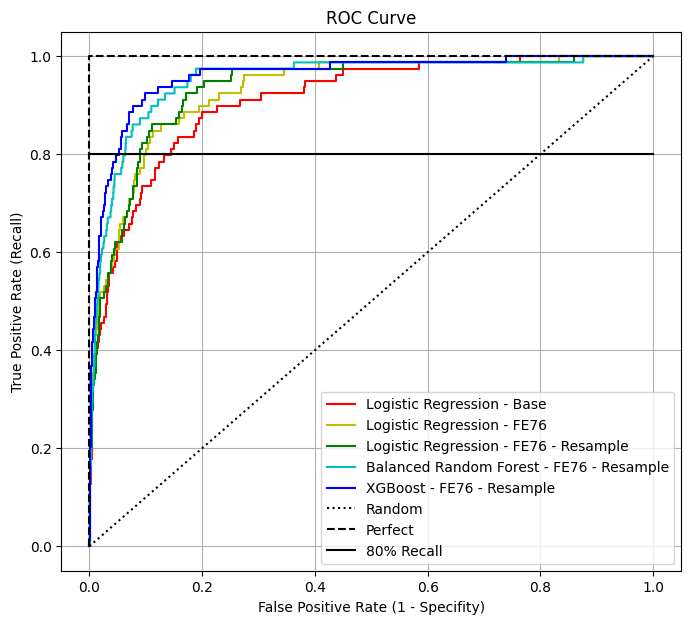

In [27]:
fpr_lr1, tpr_lr1, thr_lr1 = roc_curve(y_test, model_lr_base.predict_proba(Xb_test)[:,1])
fpr_lr2, tpr_lr2, thr_lr2 = roc_curve(y_test, model_lr_fe76.predict_proba(X1_test)[:,1])
fpr_lr3, tpr_lr3, thr_lr3 = roc_curve(y_test, model_lr_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr4, tpr_lr4, thr_lr4 = roc_curve(y_test, model_rf_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr5, tpr_lr5, thr_lr5 = roc_curve(y_test, model_xgb_fe76_rsmpl.predict_proba(X1_test)[:,1])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr_lr1, tpr_lr1, 'r-', label = 'Logistic Regression - Base')
plt.plot(fpr_lr2, tpr_lr2, 'y-', label = 'Logistic Regression - FE76')
plt.plot(fpr_lr3, tpr_lr3, 'g-', label = 'Logistic Regression - FE76 - Resample')
plt.plot(fpr_lr4, tpr_lr4, 'c-', label = 'Balanced Random Forest - FE76 - Resample')
plt.plot(fpr_lr5, tpr_lr5, 'b-', label = 'XGBoost - FE76 - Resample')

plt.plot([0,1],[0,1],'k:',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
plt.plot([0,1],[0.8,0.8],'k-',label='80% Recall')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.show()